In [2]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Ensemble model using an image captioning and ranking example
<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/run_inference_multi_model.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/run_inference_multi_model.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>

When performing complex tasks like image captioning, using a single ML model may not be the best solution.


This notebook shows how to implement a cascade model in Apache Beam using the [RunInference API](https://beam.apache.org/documentation/sdks/python-machine-learning/). The RunInference API enables you to run your Beam transforms as part of your pipeline for optimal machine learning inference.

For more information about the RunInference API, review the [RunInference notebook](https://colab.research.google.com/drive/111USL4VhUa0xt_mKJxl5nC1YLOC8_yF4?usp=sharing#scrollTo=746b67a7-3562-467f-bea3-d8cd18c14927) or the [Beam ML documentation](https://beam.apache.org/documentation/ml/overview/).

**Note:** All images are licensed CC-BY, and creators are listed in the [LICENSE.txt](https://storage.googleapis.com/apache-beam-samples/image_captioning/LICENSE.txt) file.

## Image captioning with cascade models

Image captioning has various applications, such as image indexing for information retrieval, virtual assistant training, and natural language processing.

This example shows how to generate captions on a a large set of images. Apache Beam is the ideal tool to handle this workflow. We use two models for this task:

* [BLIP](https://github.com/salesforce/BLIP): Generates a set of candidate captions for a given image.
* [CLIP](https://github.com/openai/CLIP): Ranks the generated captions based on accuracy.

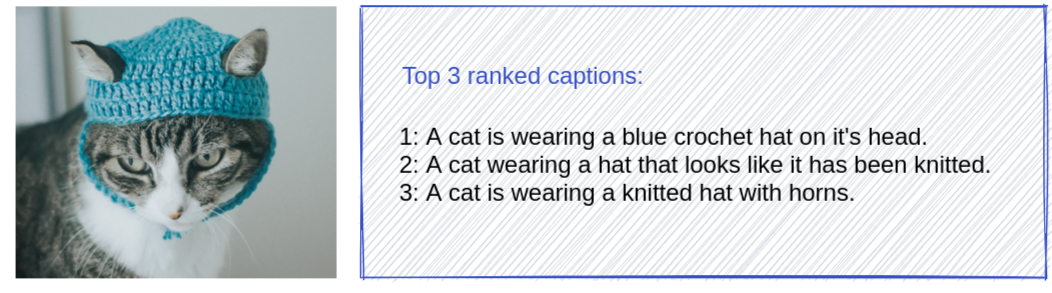

The steps to build this pipeline are as follows:
* Read the images.
* Preprocess the images for caption generation for inference with the BLIP model.
* Run inference with BLIP to generate a list of caption candidates.
* Aggregate the generated captions with their source image.
* Preprocess the aggregated image-caption pairs to rank them with CLIP.
* Run inference with CLIP to generate the caption ranking.
* Print the image names and the captions sorted according to their ranking.


The following diagram illustrates the steps in the inference pipelines used in this notebook.

In [1]:
#@title Diagram
from IPython.display import Image
Image(url='https://storage.googleapis.com/apache-beam-samples/image_captioning/beam_ensemble_diagram.png', width=2000)

## Dependencies

This section shows how to install the dependencies for this example.

The RunInference library is available in the Apache Beam SDK versions 2.40 and later.

In [1]:
!pip install --upgrade pip --quiet
!pip install transformers==4.30.2 --quiet
!pip install timm==0.4.12 --quiet
!pip install ftfy==6.1.1 --quiet
!pip install spacy==3.4.1 --quiet
!pip install fairscale==0.4.4 --quiet
!pip install apache_beam[gcp]>=2.48.0

# To use the newly installed versions, restart the runtime.
exit()

In [1]:
import requests
import os
import urllib
import json
import io
from io import BytesIO
from typing import Sequence
from typing import Iterator
from typing import Iterable
from typing import Tuple
from typing import Optional
from typing import Dict
from typing import List
from typing import Any

import apache_beam as beam
from apache_beam.ml.inference.base import PredictionResult
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.ml.inference.base import KeyedModelHandler
from apache_beam.ml.inference.base import PredictionResult
from apache_beam.ml.inference.base import RunInference
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerTensor
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerKeyedTensor
from transformers import CLIPProcessor
from transformers import CLIPTokenizer
from transformers import CLIPModel
from transformers import CLIPConfig
from transformers import CLIPFeatureExtractor
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Install CLIP dependencies

Download and install the CLIP dependencies.

In [2]:
! git lfs install
! git clone https://huggingface.co/openai/clip-vit-base-patch32

Git LFS initialized.
Cloning into 'clip-vit-base-patch32'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 51 (delta 1), reused 0 (delta 0), pack-reused 45
Unpacking objects: 100% (51/51), done.
Filtering content: 100% (3/3), 1.69 GiB | 66.58 MiB/s, done.


In [3]:
# CLIP model and component configs paths
clip_feature_extractor_config_path = '/content/clip-vit-base-patch32/preprocessor_config.json'
clip_tokenizer_vocab_config_path = '/content/clip-vit-base-patch32/vocab.json'
clip_merges_config_path = '/content/clip-vit-base-patch32/merges.txt'
clip_model_config_path = '/content/clip-vit-base-patch32/config.json'
clip_state_dict_path = '/content/clip-vit-base-patch32/pytorch_model.bin'


### Install BLIP dependencies

Download and install the BLIP dependencies.

In [4]:
!git clone https://github.com/salesforce/BLIP
%cd /content/BLIP

Cloning into 'BLIP'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 274 (delta 130), reused 117 (delta 117), pack-reused 118
Receiving objects: 100% (274/274), 7.04 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (150/150), done.
/content/BLIP


In [5]:
from BLIP.models.blip import blip_decoder

!gdown 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth'
# The blip model is saved as a checkpoint, load it and save it as a state dict since RunInference required
# a state dict for model instantiation
blip_state_dict_path = '/content/BLIP/blip_state_dict.pth'
torch.save(torch.load('/content/BLIP/model*_base_caption.pth')['model'], blip_state_dict_path)

Downloading...
From: https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth
To: /content/BLIP/model*_base_caption.pth
100% 896M/896M [00:04<00:00, 198MB/s]


### Install I/O helper functions

Download and install the dependencies for the I/O helper functions.

In [6]:
class ReadImagesFromUrl(beam.DoFn):
  """
  Read an image from a given URL and return a tuple of the images_url
  and image data.
  """
  def process(self, element: str) -> Tuple[str, Image.Image]:
    response = requests.get(element)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return [(element, image)]


class FormatCaptions(beam.DoFn):
  """
  Print the image name and its most relevant captions after CLIP ranking.
  """
  def __init__(self, number_of_top_captions: int):
    self._number_of_top_captions = number_of_top_captions

  def process(self, element: Tuple[str, List[str]]):
    image_url, caption_list = element
    caption_list = caption_list[:self._number_of_top_captions]
    img_name = os.path.basename(image_url).rsplit('.')[0]
    print(f'Image: {img_name}')
    print(f'\tTop {self._number_of_top_captions} captions ranked by CLIP:')
    for caption_rank, caption_prob_pair in enumerate(caption_list):
      print(f'\t\t{caption_rank+1}: {caption_prob_pair[0]}. (Caption probability: {caption_prob_pair[1]:.2f})')
    print('\n')

## Intermediate processing functions

Define the preprocessing and postprocessing functions for each of the models.

To prepare the instance for processing bundles of elements by initializing and to cache the processing transform resources, use `DoFn.setup()`.
This step avoids unnecessary re-initializations on every invocation of the processing method.

### Define BLIP functions
Define the preprocessing and postprocessing functions for BLIP.

In [7]:
class PreprocessBLIPInput(beam.DoFn):

  """
  Process the raw image input to a format suitable for BLIP inference. The processed
  images are duplicated to the number of desired captions per image.

  Preprocessing transformation taken from:
  https://github.com/salesforce/BLIP/blob/d10be550b2974e17ea72e74edc7948c9e5eab884/predict.py
  """

  def __init__(self, captions_per_image: int):
    self._captions_per_image = captions_per_image

  def setup(self):

    # Initialize the image transformer.
    self._transform = transforms.Compose([
      transforms.Resize((384, 384),interpolation=InterpolationMode.BICUBIC),
      transforms.ToTensor(),
      transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])

  def process(self, element):
    image_url, image = element
    # The following lines provide a workaround to turn off BatchElements.
    preprocessed_img = self._transform(image).unsqueeze(0)
    preprocessed_img = preprocessed_img.repeat(self._captions_per_image, 1, 1, 1)
    # Parse the processed input to a dictionary to a format suitable for RunInference.
    preprocessed_dict = {'inputs': preprocessed_img}

    return [(image_url, preprocessed_dict)]

class PostprocessBLIPOutput(beam.DoFn):
  """
  Process the PredictionResult to get the generated image captions
  """
  def process(self, element : Tuple[str, Iterable[PredictionResult]]):
    image_url, prediction = element

    return [(image_url, prediction.inference)]

### Define CLIP functions

Define the preprocessing and postprocessing functions for CLIP.

In [8]:
class PreprocessCLIPInput(beam.DoFn):

  """
  Process the image-caption pair to a format suitable for CLIP inference.

  After grouping the raw images with the generated captions, we need to
  preprocess them before passing them to the ranking stage (CLIP model).
  """

  def __init__(self,
               feature_extractor_config_path: str,
               tokenizer_vocab_config_path: str,
               merges_file_config_path: str):

    self._feature_extractor_config_path = feature_extractor_config_path
    self._tokenizer_vocab_config_path = tokenizer_vocab_config_path
    self._merges_file_config_path = merges_file_config_path


  def setup(self):

    # Initialize the CLIP feature extractor.
    feature_extractor_config = CLIPConfig.from_pretrained(self._feature_extractor_config_path)
    feature_extractor = CLIPFeatureExtractor(feature_extractor_config)

    # Initialize the CLIP tokenizer.
    tokenizer = CLIPTokenizer(self._tokenizer_vocab_config_path,
                              self._merges_file_config_path)

    # Initialize the CLIP processor used to process the image-caption pair.
    self._processor = CLIPProcessor(feature_extractor=feature_extractor,
                                    tokenizer=tokenizer)

  def process(self, element: Tuple[str, Dict[str, List[Any]]]):

    image_url, image_captions_pair = element
    # Unpack the image and captions after grouping them with 'CoGroupByKey()'.
    image = image_captions_pair['image'][0]
    captions = image_captions_pair['captions'][0]
    preprocessed_clip_input = self._processor(images = image,
                                              text = captions,
                                              return_tensors="pt",
                                              padding=True)

    image_url_caption_pair = (image_url, captions)
    return [(image_url_caption_pair, preprocessed_clip_input)]


class RankCLIPOutput(beam.DoFn):
  """
  Process the output of CLIP to get the captions sorted by ranking order.

  The logits are the output of the CLIP model. Here, we apply a softmax activation
  function to the logits to get the probabilistic distribution of the relevance
  of each caption to the target image. After that, we sort the captions in descending
  order with respect to the probabilities as a caption-probability pair.
  """

  def process(self, element : Tuple[Tuple[str, List[str]], Iterable[PredictionResult]]):
    (image_url, captions), prediction = element
    prediction_results = prediction.inference
    prediction_probs = prediction_results.softmax(dim=-1).cpu().detach().numpy()
    ranking = np.argsort(-prediction_probs)
    sorted_caption_prob_pair = [(captions[idx], prediction_probs[idx]) for idx in ranking]

    return [(image_url, sorted_caption_prob_pair)]

## Model handlers

A `ModelHandler` is Beam's method for defining the configuration needed to load and invoke your model. Since both the BLIP and CLIP models use Pytorch and take KeyedTensors as inputs, we will use `PytorchModelHandlerKeyedTensor` for both.

We will use a `KeyedModelHandler` for both models to attach a key to the general `ModelHandler`.
The key is used for the following purposes:
* To keep a reference to the image that the inference is associated with.
* To aggregate transforms of different inputs.
* To run postprocessing steps correctly.

In this example, we use the `image_url` as the key.

## Generate captions with BLIP

Use BLIP to generate a set of candidate captions for a given image.

In [10]:
MAX_CAPTION_LENGTH = 80
MIN_CAPTION_LENGTH = 10
# Increasing Beam search might improve the quality of the captions,
# but also results in more compute time
NUM_BEAMS = 1


In [10]:
def blip_keyed_tensor_inference_fn(
    batch: Sequence[Dict[str, torch.Tensor]],
    model: torch.nn.Module,
    device: str,
    inference_args: Optional[Dict[str, Any]] = None,
    model_id: Optional[str] = None,
) -> Iterable[PredictionResult]:
  # By default, Beam batches inputs for bulk inference and calls model(batch)
  # Since we want to call model.generate on a single unbatched input (BLIP/CLIP
  # don't handle batched inputs), we define a custom inference function.
  captions = model.generate(batch[0]['inputs'],
                            sample=True,
                            num_beams=NUM_BEAMS,
                            max_length=MAX_CAPTION_LENGTH,
                            min_length=MIN_CAPTION_LENGTH)
  return [PredictionResult(batch[0], captions, model_id)]


BLIP_model_handler = PytorchModelHandlerKeyedTensor(
    state_dict_path=blip_state_dict_path,
    model_class=blip_decoder,
    inference_fn=blip_keyed_tensor_inference_fn,
    max_batch_size=1)

BLIP_keyed_model_handler = KeyedModelHandler(BLIP_model_handler)

## Rank captions with CLIP

Use CLIP to rank the generated captions based on the accuracy with which they represent the image.

In [11]:
def clip_keyed_tensor_inference_fn(
    batch: Sequence[Dict[str, torch.Tensor]],
    model: torch.nn.Module,
    device: str,
    inference_args: Optional[Dict[str, Any]] = None,
    model_id: Optional[str] = None,
) -> Iterable[PredictionResult]:
  # By default, Beam batches inputs for bulk inference and calls model(batch)
  # Since we want to call model on a single unbatched input (BLIP/CLIP don't
  # handle batched inputs), we define a custom inference function.
  output = model(**batch[0], **inference_args)
  return [PredictionResult(batch[0], output.logits_per_image[0], model_id)]


CLIP_model_handler = PytorchModelHandlerKeyedTensor(
    state_dict_path=clip_state_dict_path,
    model_class=CLIPModel,
    model_params={'config': CLIPConfig.from_pretrained(clip_model_config_path)},
    inference_fn=clip_keyed_tensor_inference_fn,
    max_batch_size=1)

CLIP_keyed_model_handler = KeyedModelHandler(CLIP_model_handler)


## Specify the images to display

This section demonstrates how to specify the images to display for captioning.

In [12]:
images_url = ['https://storage.googleapis.com/apache-beam-samples/image_captioning/Paris-sunset.jpeg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/Wedges.jpeg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/Hamsters.jpeg']

Visualize the images to use for captioning.

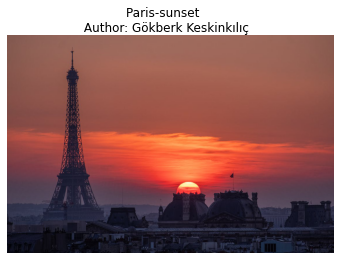

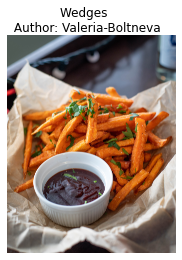

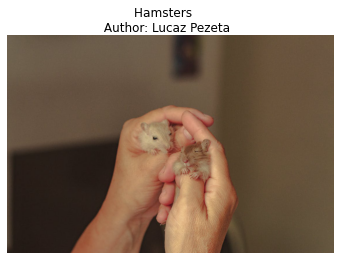

In [ ]:
#@title
license_txt_url = 'https://storage.googleapis.com/apache-beam-samples/image_captioning/LICENSE.txt'
license_dict = json.loads(urllib.request.urlopen(license_txt_url).read().decode("utf-8"))

for image_url in images_url:
  response = requests.get(image_url)
  image = Image.open(BytesIO(response.content)).convert('RGB')
  image_author = license_dict[image_url]
  fig = plt.figure()
  title = f"{os.path.basename(image_url).rsplit('.')[0]} \n Author: {image_author}"
  fig.suptitle(title, fontsize=12)
  plt.axis('off')
  plt.imshow(image)


## Initialize the pipeline run parameters

Specify the number of captions generated per image and the number of captions to display with each image.

In [13]:
# Number of captions generated per image.
NUM_CAPTIONS_PER_IMAGE = 10

# Number of top captions to display.
NUM_TOP_CAPTIONS_TO_DISPLAY = 3


## Run the pipeline

This example uses raw images from the `read_images` pipeline as inputs for both models. Each model needs to preprocess the raw images differently, because they require a different embedding representation for image captioning and for image-captions pair ranking.

To aggregate the raw images with the generated caption by their key (the image URL), this example uses `CoGroupByKey`. This process produces a tuple of image-captions pairs that is then passed to the CLIP transform and used for ranking.

In [14]:
with beam.Pipeline() as pipeline:

  read_images = (
            pipeline
            | "ReadUrl" >> beam.Create(images_url)
            | "ReadImages" >> beam.ParDo(ReadImagesFromUrl()))

  blip_caption_generation = (
            read_images
            | "PreprocessBlipInput" >> beam.ParDo(PreprocessBLIPInput(NUM_CAPTIONS_PER_IMAGE))
            | "GenerateCaptions" >> RunInference(BLIP_keyed_model_handler)
            | "PostprocessCaptions" >> beam.ParDo(PostprocessBLIPOutput()))

  clip_captions_ranking = (
            ({'image' : read_images, 'captions': blip_caption_generation})
            | "CreateImageCaptionPair" >> beam.CoGroupByKey()
            | "PreprocessClipInput" >> beam.ParDo(
                PreprocessCLIPInput(
                    clip_feature_extractor_config_path,
                    clip_tokenizer_vocab_config_path,
                    clip_merges_config_path))
            | "GetRankingLogits" >> RunInference(CLIP_keyed_model_handler)
            | "RankClipOutput" >> beam.ParDo(RankCLIPOutput())
            )

  clip_captions_ranking | "FormatCaptions" >> beam.ParDo(FormatCaptions(NUM_TOP_CAPTIONS_TO_DISPLAY))


Image: Paris-sunset
	Top 3 captions ranked by CLIP:
		1: the setting sun is reflected in an orange setting sky over paris. (Caption probability: 0.28)
		2: the sun rising above the eiffel tower over paris. (Caption probability: 0.23)
		3: the sun setting over the eiffel tower and rooftops. (Caption probability: 0.15)


Image: Wedges
	Top 3 captions ranked by CLIP:
		1: sweet potato fries with ketchup served in bowl. (Caption probability: 0.73)
		2: this is a plate of sweet potato fries with ketchup. (Caption probability: 0.16)
		3: sweet potato fries and a dipping sauce are on the tray. (Caption probability: 0.06)


Image: Hamsters
	Top 3 captions ranked by CLIP:
		1: person holding two small animals in their hands. (Caption probability: 0.62)
		2: a person's hand holding a small hamster in front of them. (Caption probability: 0.20)
		3: a person holding a small animal in their hands. (Caption probability: 0.09)




# Conclusion

After running the pipeline, you can see the captions generated by the BLIP model and ranked by the CLIP model with all of our pre/postprocessing logic applied.
As you can see, running multi-model inference is easy with the power of Beam.


# Resources

* [RunInference API](https://beam.apache.org/documentation/sdks/python-machine-learning/): an official guide to the RunInference API.
* [RunInference Demo](https://colab.research.google.com/drive/10iPQTCmaLJL4_OohS00R9Wmor6d57JkS#scrollTo=ZVtBsKDgW1dl): an ensemble model demo in Colab.
* [The advantages of having a DAG and what it unlocks for you](https://beam.apache.org/documentation/dsls/dataframes/differences-from-pandas): a guide on the advantages of using a Beam DAG for ML workflow orchestration and inference.